# Compare methods using lupus data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import numpy as np
import scanpy as sc

In [2]:
data_path = '/data_volume/memento/lupus_bulk/'

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [4]:
pal = [(64/255,224/255,208/255)]+sns.color_palette("Greys", 10)[4:]

### Compute the concordance curve

In [5]:
def concordance_curve(ref1, ref2, ref3, ref4, x, k=300):
    overlap = []
    for i in range(1, k+1):
        
        a = len(set(x[:i]) & set(ref1[:i]))
        b = len(set(x[:i]) & set(ref2[:i]))
        c = len(set(x[:i]) & set(ref3[:i]))
        d = len(set(x[:i]) & set(ref4[:i]))
        overlap.append((a+b+c+d)/4)
        
    return np.arange(1, k+1), np.array(overlap)

In [6]:
def concordance_auc(ref1, ref2, ref3, ref4, x, k=100):
    count = 0
    for i in range(1, k+1):
        
        a = len(set(x[:i]) & set(ref1[:i]))
        b = len(set(x[:i]) & set(ref2[:i]))
        c = len(set(x[:i]) & set(ref3[:i]))
        d = len(set(x[:i]) & set(ref4[:i]))
        count += (a+b+c+d)/4
        
    return count / (k*(k+1)/2)

### Read results with repeated trials

In [7]:
all_results = []
for numcells in [100, 500, 10000]:
    for trial in range(50):        
        name_paths = [
            ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']), 
            ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('edgeR','T4_vs_cM.pseudobulk.edger_lrt.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            # ('edgeR_qlft','T4_vs_cM.pseudobulk.edger_qlft.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),

            ('DESeq2','T4_vs_cM.pseudobulk.deseq2_wald.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('t-test','{}_{}_t.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('MWU','{}_{}_mwu.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            # ('MAST','T4_vs_cM.sc.MAST.{}.{}.csv'.format(numcells, trial), ['coef','Pr(>Chisq)', 'fdr']),
            ('memento', '{}_{}_quasiGLM.csv'.format(numcells, trial), ['coef','pval', 'fdr']),
        ]
        results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
        gene_lists = [set(res.index) for res in results]
        genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
        results = [res.loc[genes].sort_values('FDR') for res in results]

        scores = [
            (name_paths[idx+4][0].replace('_', '\n'), numcells, trial, concordance_auc(
                results[0].index, 
                results[1].index, 
                results[2].index,
                results[3].index,
                res.index)) for idx, res in enumerate(results[4:])]
        all_results+=scores
        
        curves = [
            concordance_curve(
                results[0].index, 
                results[1].index, 
                results[2].index,
                results[3].index,
                res.index) for res in results[4:]]

In [8]:
df = pd.DataFrame(all_results, columns=['name', 'numcells','trials', 'auc'])

<Axes: xlabel='auc', ylabel='name'>

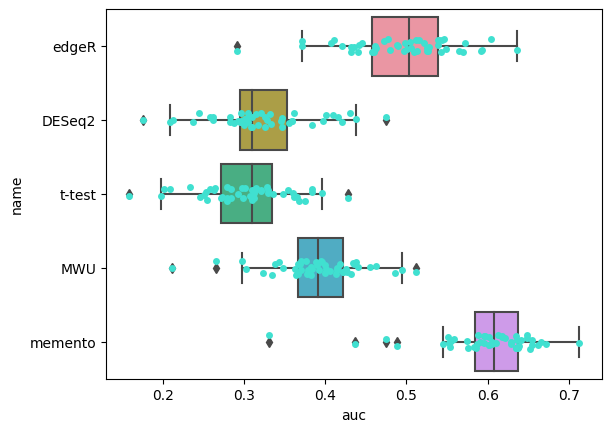

In [9]:
sns.boxplot(y='name', x='auc', data=df.query('numcells == 100'))
sns.stripplot(y='name', x='auc', data=df.query('numcells == 100'))

<Axes: xlabel='auc', ylabel='name'>

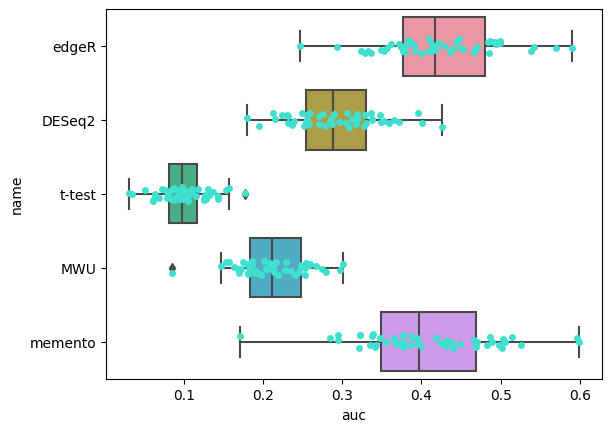

In [10]:
sns.boxplot(y='name', x='auc', data=df.query('numcells == 500'))
sns.stripplot(y='name', x='auc', data=df.query('numcells == 500'))

/tmp/ipykernel_726386/1023455804.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_726386/1023455804.py:14: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.stripplot(


Text(0, 0.5, '')

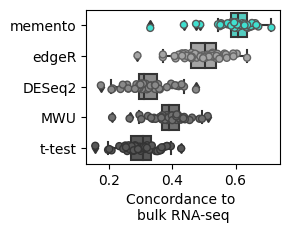

In [11]:
plt.figure(figsize=(2.5,2))
sns.boxplot(
    y='name',
    x='auc', 
    data=df.query('numcells==100'), 
    order=[
        'memento',
        'edgeR',
        'DESeq2',
        # 'MAST',
        'MWU',
        't-test',],
    palette=pal)
sns.stripplot(
    y='name',
    x='auc', 
    data=df.query('numcells==100'), 
    order=[
        'memento',
        'edgeR',
        'DESeq2',
        # 'MAST',
        'MWU',
        't-test',],
    linewidth=1,
    palette=pal)
plt.xlabel('Concordance to \nbulk RNA-seq')
plt.ylabel('')
# plt.savefig('lupus_bulk_comparison.pdf', bbox_inches='tight')

/tmp/ipykernel_726386/3812398015.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_726386/3812398015.py:14: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.stripplot(


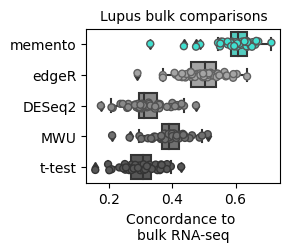

In [14]:
plt.figure(figsize=(2.5,2))
sns.boxplot(
    y='name',
    x='auc', 
    data=df.query('numcells==100'), 
    order=[
        'memento',
        'edgeR',
        'DESeq2',
        # 'MAST',
        'MWU',
        't-test',],
    palette=pal)
sns.stripplot(
    y='name',
    x='auc', 
    data=df.query('numcells==100'), 
    order=[
        'memento',
        'edgeR',
        'DESeq2',
        # 'MAST',
        'MWU',
        't-test',],
    linewidth=1,
    palette=pal)
plt.xlabel('Concordance to \nbulk RNA-seq')
plt.ylabel('')
plt.title('Lupus bulk comparisons')
plt.savefig('lupus_bulk_comparison.pdf', bbox_inches='tight')

In [72]:
df.sort_values(['name', 'trials']).query('name == "edgeR"').head(30)

,name,numcells,trials,auc
0,edgeR,100,0,0.370693
250,edgeR,10000,0,0.211188
5,edgeR,100,1,0.565396
255,edgeR,10000,1,0.360198
10,edgeR,100,2,0.439703
260,edgeR,10000,2,0.500594
15,edgeR,100,3,0.505842
265,edgeR,10000,3,0.353218
20,edgeR,100,4,0.604208
270,edgeR,10000,4,0.432327


In [19]:
all_results = []
for numcells in [10000]:#[50, 100, 150, 200, 10000]:
    for trial in range(5):        
        name_paths = [
            ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.{}.{}.csv'.format(200, trial), ['logFC','PValue', 'FDR']), 
            ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.{}.{}.csv'.format(200, trial), ['logFC','PValue', 'FDR']),
            ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.{}.{}.csv'.format(200, trial), ['log2FoldChange','pvalue', 'padj']),
            ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.{}.{}.csv'.format(200, trial), ['log2FoldChange','pvalue', 'padj']),
            # ('edgeR','T4_vs_cM.pseudobulk.edger_lrt.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            # ('DESeq2','T4_vs_cM.pseudobulk.deseq2_wald.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            # ('t-test','T4_vs_cM.sc.ttest.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            # ('MWU','T4_vs_cM.sc.mwu.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            # ('MAST','T4_vs_cM.sc.MAST.{}.{}.csv'.format(numcells, trial), ['coef','Pr(>Chisq)', 'fdr']),
            # ('memento', '{}_{}_quasiGLM.csv'.format(numcells, trial), ['coef','pval', 'fdr']),
        ]
        results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
        gene_lists = [set(res.index) for res in results]
        genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
        results = [res.loc[genes].sort_values('FDR') for res in results]

        scores = [
            (name_paths[idx+4][0].replace('_', '\n'), numcells, concordance_auc(
                results[0].index, 
                results[1].index, 
                results[2].index,
                results[3].index,
                res.index)) for idx, res in enumerate(results)]
        all_results+=scores
        
        curves = [
            concordance_curve(
                results[0].index, 
                results[1].index, 
                results[2].index,
                results[3].index,
                res.index) for res in results[4:]]

IndexError: list index out of range

In [26]:
len(results)

4

In [27]:
len(scores)

0

In [21]:
len(results)

4

In [19]:
scores

[]

In [10]:
df = pd.DataFrame(all_results, columns=['name', 'numcells', 'auc'])

df['numcells'] = df['numcells'].astype('category')

In [12]:
df

,name,numcells,auc
0,memento,10000,0.061390
1,memento,10000,0.135703
2,memento,10000,0.111013
3,memento,10000,0.040321
4,memento,10000,0.028882


<Axes: xlabel='numcells', ylabel='auc'>

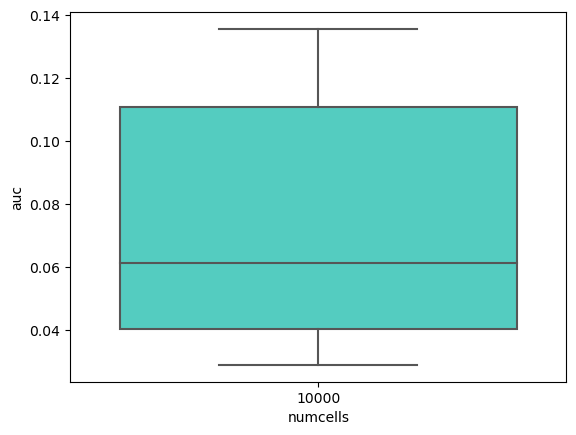

In [11]:
sns.boxplot(
    x='numcells',
y='auc', 
    data=df, 
    palette=pal)

<AxesSubplot: xlabel='numcells', ylabel='auc'>

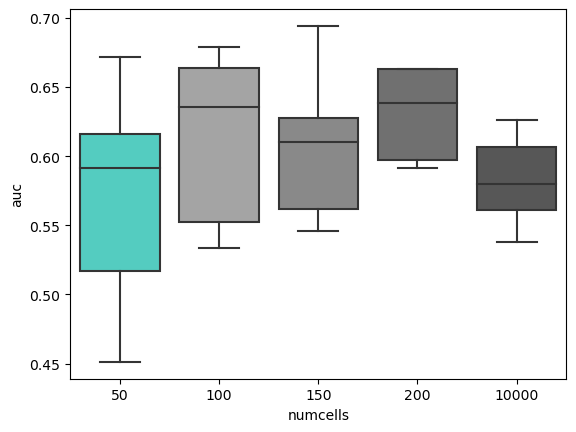

In [10]:
sns.boxplot(
    x='numcells',
y='auc', 
    data=df, 
    palette=pal)

### Single example

In [139]:
name_paths = [
    ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.csv', ['logFC','PValue', 'FDR']), 
    ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.csv', ['logFC','PValue', 'FDR']),
    ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.csv', ['log2FoldChange','pvalue', 'padj']),
    ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.csv', ['log2FoldChange','pvalue', 'padj']),
    ('pseudobulk_edger','T4_vs_cM.pseudobulk.edger.csv', ['logFC','PValue', 'FDR']),
    ('pseudobulk_deseq2','T4_vs_cM.pseudobulk.deseq2.csv', ['log2FoldChange','pvalue', 'padj']),
    ('ttest','T4_vs_cM.sc.ttest.csv', ['logFC','PValue', 'FDR']),
    ('weighted_mean_GLM', 'T4_vs_cM.sc.weighted_mean_glm.csv', ['logFC','PValue', 'FDR']),
]
results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
gene_lists = [set(res.index) for res in results]
genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
results = [res.loc[genes].sort_values('FDR') for res in results]

curves = [
    concordance_curve(
        results[0].index, 
        results[1].index, 
        results[2].index,
        results[3].index,
        res.index) for res in results[4:]]

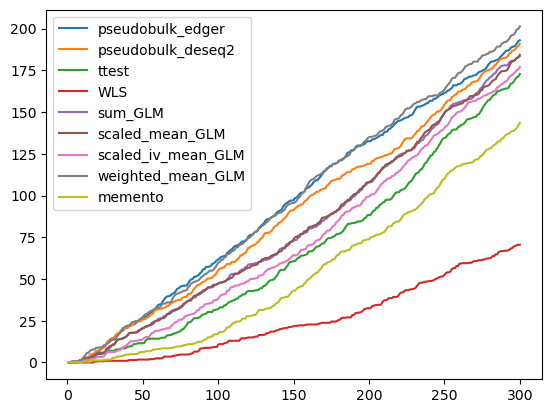

In [142]:
for idx, (x,y) in enumerate(curves):
    plt.plot(x,y, label=name_paths[idx+4][0])
plt.legend()